In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%cd  /content/gdrive/MyDrive/DSLC-2017/
! ls

/content/gdrive/MyDrive/DSLC-2017
3d_image_classification.h5   test_data-512-512.npy
DATA			     toy-dataset
imageDataNew-50-50-20.npy    toy-dataset.zip
lung_classification_v1.h5    train_data-256-256-3.npy
lung_classification_v7.h5    train_data-256-256-46.npy
lung_classification_v8.h5    train_data-512-512-3.npy
mobileNet_finetune_final.h5  train_data-512-512.npy
resnet_finetune_final.h5     vgg16_finetune_final.h5
test_data-256-256-3.npy      vgg16_finetune.h15
test_data-256-256-46.npy     vgg16_finetune.h5
test_data-512-512-3.npy      vgg16_finetune_v2.h5


In [ ]:
import zipfile
with zipfile.ZipFile('toy-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('toy-dataset')

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 2.9MB/s 


##DATA LOADING

In [ ]:
%pylab --no-import-all
%matplotlib inline
import numpy as np
import pandas as pd
import os
import scipy.ndimage
from  pydicom import dcmread
import cv2
images_path = '/content/gdrive/MyDrive/DSLC-2017/DATA/'


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


##DATA PREPROCESSING

In [ ]:
def get_3d_data(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [ ]:
patients = os.listdir(images_path)
patients.sort()
len(patients)

47

In [ ]:
sample_image = get_3d_data(images_path + patients[6])
sample_image = scipy.ndimage.zoom(sample_image.astype(np.float), 0.5)
sample_image.shape

(98, 256, 256)

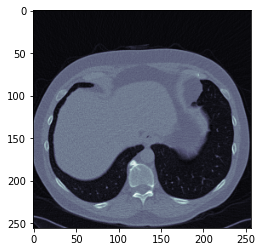

In [ ]:
sample_image[sample_image == -2000] = 0
pylab.imshow(sample_image[70], cmap=pylab.cm.bone)
pylab.show()

In [ ]:
img_std = np.std(sample_image)
img_avg = np.average(sample_image)
std_image = np.clip((sample_image - img_avg + img_std) / (img_std * 2), 0, 1)

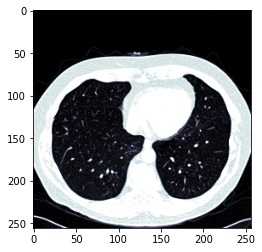

In [ ]:
pylab.imshow(std_image[60], cmap=pylab.cm.bone)
pylab.show()

In [ ]:
labels_csv = pd.read_csv('/content/gdrive/MyDrive/DSLC-2017/DATA/stage1_labels.csv',index_col=0)
patients=patients[:46]
# Remove the (single) unlabbeled patient from ourist

patients = labels_csv.loc[patients].dropna().index

# And finally get the training labels
train_labels = labels_csv.loc[patients].cancer.astype(np.float16).to_numpy()
train_label = train_labels.reshape([len(train_labels)])
train_labels = train_labels.reshape([len(train_labels),1])
test_labels = train_labels[:6].astype('float32')
train_labels = train_labels[6:].astype('float32')
train_labels
# patients.shape

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


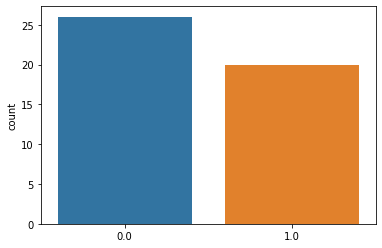

In [ ]:
import seaborn as sns
sns.countplot(train_label)

In [ ]:
def process_image(path):
    img = get_3d_data(path)
    img[img == -2000] = 0
    img = scipy.ndimage.zoom(img.astype(np.float), [0.5, 0.5, 0.5])
    print(img.shape)
    img_std = np.std(img)
    img_avg = np.average(img)
    return np.clip((img - img_avg + img_std) / (img_std * 2), 0, 1).astype(np.float16)

In [ ]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  train_features = np.zeros([len(patients), 128, 256, 256, 1], np.float16)
  for i in range(len(patients)):
    print(i)
    f = process_image(images_path + patients[i])
    val=f.shape[0]
    temp=f
    if val > 128 :
      f=f[:128]
    else:
      for j in range(val,128,val):
        if 128-j < val:
          size=temp[:128-j]
          f = np.concatenate([f, size]) 
        else:
          f = np.concatenate([f, temp]) # Pads the image

      f = np.concatenate([f, np.zeros([128 - f.shape[0], 256, 256], np.float32)])

    f = f.reshape([128, 256, 256, 1]) 
    train_features[i] = f
  train_features.shape

0
(67, 256, 256)
1
(68, 256, 256)
2
(64, 256, 256)
3
(66, 256, 256)
4
(55, 256, 256)
5
(102, 256, 256)
6
(98, 256, 256)
7
(140, 256, 256)
8
(62, 256, 256)
9
(82, 256, 256)
10
(122, 256, 256)
11
(68, 256, 256)
12
13
(110, 256, 256)
14
(74, 256, 256)
15
(218, 256, 256)
16
(63, 256, 256)
17
(86, 256, 256)
18
(56, 256, 256)
19
(76, 256, 256)
20
(107, 256, 256)
21
(61, 256, 256)
22
(83, 256, 256)
23
(113, 256, 256)
24
(102, 256, 256)
25
(132, 256, 256)
26
27
(71, 256, 256)
28
(74, 256, 256)
29
(65, 256, 256)
30
(86, 256, 256)
31
(85, 256, 256)
32
(64, 256, 256)
33
(78, 256, 256)
34
(94, 256, 256)
35
(86, 256, 256)
36
(74, 256, 256)
37
(132, 256, 256)
38
39
(110, 256, 256)
40
(65, 256, 256)
41
(83, 256, 256)
42
(71, 256, 256)
43
(72, 256, 256)
44
(72, 256, 256)
45
(64, 256, 256)


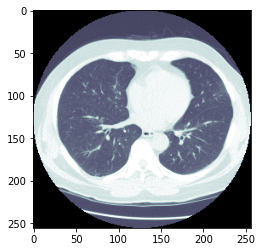

In [ ]:
sample_image=f.reshape(128,256,256)
# for i in range(0,128):
pylab.imshow(sample_image[100], cmap=pylab.cm.bone)
pylab.show()

In [ ]:
import numpy as np
train_patients = train_features[6:]
test_patients = train_features[:6]
print(len(train_patients))
np.save('train_data-{}-{}-{}.npy'.format(256,256,2), train_patients)
np.save('test_data-{}-{}-{}.npy'.format(256,256,2), test_patients)

2


In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
load_test = np.load('test_data-256-256-46.npy')
np.load = np_load_old

test_patients=np.zeros([len(load_test), 128, 256, 256, 1], np.float32)
for i in range(len(load_test)):
  val=load_test[i].astype('float32')
  test_patients[i]=val

In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
load_test = np.load('train_data-256-256-46.npy')
np.load = np_load_old

train_patients=np.zeros([len(load_test), 128, 256, 256, 1], np.float32)
for i in range(len(load_test)):
  val=load_test[i].astype('float32')
  train_patients[i]=val
train_patients.shape

(40, 128, 256, 256, 1)

In [ ]:
train_patients = train_patients
test_patients = test_patients
print(test_labels.shape,test_patients.shape)

(6, 1) (6, 128, 256, 256, 1)


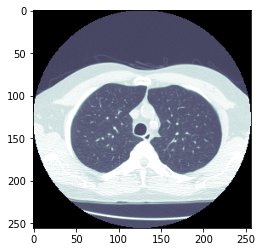

In [ ]:
sample_image = train_patients[1].reshape(128,256,256)
# for i in range(0,128):
pylab.imshow(sample_image[120], cmap=pylab.cm.bone)
pylab.show()

##MODEL TRAINING

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
import h5py
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# tf.debugging.set_log_device_placement(True)
# with tf.device('/GPU:0'):
model = Sequential()
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=train_patients.shape[1:]))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_89 (Conv3D)           (None, 126, 254, 254, 16) 448       
_________________________________________________________________
max_pooling3d_82 (MaxPooling (None, 63, 127, 127, 16)  0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 63, 127, 127, 16)  64        
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 61, 125, 125, 32)  13856     
_________________________________________________________________
max_pooling3d_83 (MaxPooling (None, 30, 62, 62, 32)    0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 30, 62, 62, 32)    128       
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 28, 60, 60, 64)  

In [ ]:
initial_learning_rate = 1e-5

model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  metrics=['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "lung_classification_v11.h5", save_best_only=True
)

history = model.fit(train_patients, train_labels,
                batch_size=1,
                epochs=10,
                validation_split=0.1,
                callbacks=[checkpoint_cb])

Epoch 1/10
36/36 [==============================] - 21s 517ms/step - loss: 0.7998 - accuracy: 0.6389 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 2/10
36/36 [==============================] - 18s 508ms/step - loss: 0.4203 - accuracy: 0.8406 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 3/10
36/36 [==============================] - 18s 510ms/step - loss: 0.1632 - accuracy: 0.9135 - val_loss: 0.6769 - val_accuracy: 0.7500
Epoch 4/10
36/36 [==============================] - 18s 510ms/step - loss: 0.0668 - accuracy: 1.0000 - val_loss: 0.6608 - val_accuracy: 0.7500
Epoch 5/10
36/36 [==============================] - 19s 515ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.6379 - val_accuracy: 1.0000
Epoch 6/10
36/36 [==============================] - 18s 514ms/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.6182 - val_accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 18s 512ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.6116 - val_accuracy: 0.7500

##PREDICTION IN TEST DATASET

In [ ]:
model.load_weights("lung_classification_v10.h5")
# val=model.predict(np.expand_dims(train_patients[9], axis=0))[0]
# print(train_labels[9],val)
test_pred=[]
for i in range(len(test_patients)):
  val=model.predict(np.expand_dims(test_patients[i], axis=0))
  if val<0.5 :
    label=0.0
  else :
    label=1.0
  test_pred.append(label)
  print(val,test_labels[i])

[[0.2944584]] [0.]
[[0.6192387]] [1.]
[[0.32615215]] [0.]
[[0.27420735]] [0.]
[[0.38197696]] [0.]
[[0.58348966]] [1.]


In [ ]:
!pip install -q scikit-plot

## Confusion Matrix

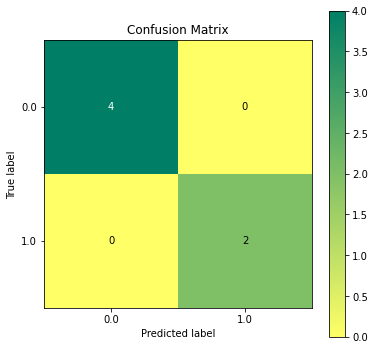

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    test_labels,test_pred,
    figsize=(6,6),cmap="summer_r")

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
matrix= confusion_matrix(test_labels,test_pred)
print(matrix)
score= accuracy_score(test_labels,test_pred)
print(score)
report= classification_report(test_labels,test_pred)
print(report)

[[4 0]
 [0 2]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



##PLOT ACCURACY VS EPOCH

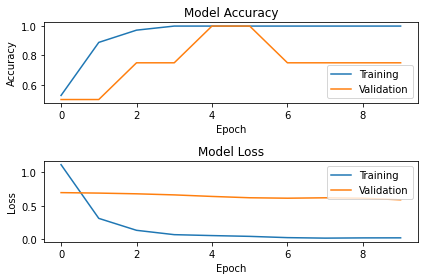

In [ ]:
# model.load_weights("lung_classification_v8.h5")
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()